In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lib.assembly_graph
import lib.plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from collections import defaultdict
from itertools import chain

from tqdm import tqdm

np.random.seed(1)

In [3]:
def simulate_sequence(n):
    sequence = ''.join(np.random.choice(['A', 'C', 'G', 'T'], size=n))
    return sequence


def collect_kmers(sequences):
    all_kmers = set()
    
    for seq in sequences:
        for i in range(len(seq) - k):
            kmer = seq[i: i + k]
            if kmer not in all_kmers:
                kmer_rc = lib.assembly_graph.reverse_complement(kmer)
                all_kmers |= set([kmer, kmer_rc])

    return all_kmers


def build_seed_from_one_sequence(sequence, k):
    # Build graph and simulate depths
    seed = defaultdict(set)
    last_kmer = sequence[:k]
    for i in range(1, len(sequence) - k):
        kmer = sequence[i: i + k]
        seed[last_kmer].add(kmer)
        last_kmer = kmer
        
    return seed

def build_depth_from_seed(seed, depth_fn):
    nodes = set(seed.keys()) | set(chain.from_iterable(seed.values()))
    depth = defaultdict(lambda: 0)
    depth.update({unitig: depth_fn(unitig) for unitig in nodes})
    return depth

In [4]:
def build_dgraph_from_seed(seed, depth):
    right, left = lib.assembly_graph.build_full_from_seed_graph(seed)
    depth = pd.Series(lib.assembly_graph.add_reverse_complement_depth(depth)).astype(float)
    assert (depth.index.isin(right.keys()) | depth.index.isin(left.keys())).all()
    dgraph = pd.DataFrame(np.zeros((len(depth), len(depth))), index=depth.index, columns=depth.index)
    for unitig in depth.index:
        dgraph.loc[unitig, right[unitig]] = 1
    return dgraph, depth

In [5]:
def initialize_messages(dgraph, depth):
    # Step -1
    send_to_r = dgraph
    send_to_l = dgraph.T
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)

    # Step 0
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)

    return send_to_r, send_to_l

In [6]:
def mean_depth(r, l, d, weight):
    # TODO: Confirm that this broadcasts correctly
    return (r + l + weight * d) / (2 + weight)


# def gmean_depth(r, l, d, weight):
#     assert weight == 1.0
#     return ((r + 1) * (l + 1) * (d + 1))**(1/3)

# def hmean_depth(r, l, d, weight):
#     assert weight == 1.0
#     return (3 / (1 / (r + 1) + 1 / (l + 1) + 1 / (d + 1)))


def iterate_messages_poc(
    send_to_r,
    send_to_l,
    depth,
    new_depth_fn=mean_depth,
    weight=1.0,
):
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    # Update depth
    next_depth = new_depth_fn(total_from_r, total_from_l, depth, weight)
    # Scale the depth so there's no overall loss.
    depth = next_depth * (depth.sum() / next_depth.sum())
    # Calculate next message
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)
    return send_to_r, send_to_l, depth


def iterate_messages(
    send_to_r,
    send_to_l,
    depth,
    new_depth_fn=mean_depth,
    weight=1.0,
):
    total_from_l = send_to_r.sum(0)
    total_from_r = send_to_l.sum(0)
    # Update depth
    next_depth = new_depth_fn(total_from_r, total_from_l, depth, weight)
    # Scale the depth so there's no overall loss.
    depth = next_depth * (depth.sum() / next_depth.sum())
    # Calculate next message
    proportions_r = np.nan_to_num(send_to_l / total_from_r)
    proportions_l = np.nan_to_num(send_to_r / total_from_l)
    send_to_r_next = (proportions_r * depth).T
    send_to_l_next = (proportions_l * depth).T
    send_to_r = send_to_r_next
    send_to_l = send_to_l_next
    return send_to_r, send_to_l, depth


def run_message_passing(seed, observed_depth, thresh=1e-3):
    dgraph, depth0 = build_dgraph_from_seed(seed, observed_depth)
    send_to_r, send_to_l = initialize_messages(dgraph, depth0)

    # Switch things to raw numpy arrays:
    send_to_r, send_to_l = send_to_r.values, send_to_l.values
    depth = depth0.values
    tbar = tqdm(position=0, leave=True)
    while True:
        send_to_r, send_to_l, new_depth = iterate_messages(
            send_to_r, send_to_l, depth, new_depth_fn=mean_depth,
        )
        delta = new_depth - depth
        change = np.sqrt(np.sum(np.square(new_depth - depth)))
        depth = new_depth
        tbar.update()
        tbar.set_postfix({'change': change})
        if change < thresh:
            print("CONVERGED")
            break
    # Recover labels
    send_to_r, send_to_l = [pd.DataFrame(send, index=dgraph.index, columns=dgraph.columns) for send in [send_to_r, send_to_l]]
    depth = pd.Series(depth, index=dgraph.index)
    return depth, send_to_r, send_to_l, depth0


# Random Sequence

In [7]:
# Simulate sequence
np.random.seed(1)
sequence = simulate_sequence(int(1e2))

seed = build_seed_from_one_sequence(sequence, 5)

# Simulate depth
depth_fn = lambda kmer: np.exp(np.random.randn() * 2)
observed_depth = build_depth_from_seed(seed, depth_fn)


depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
depth_table = pd.DataFrame(dict(old_depth=depth0, new_depth=depth))

0it [00:00, ?it/s]<ipython-input-6-168fc7a9bc61>:50: RuntimeWarning: invalid value encountered in true_divide
  proportions_r = np.nan_to_num(send_to_l / total_from_r)
<ipython-input-6-168fc7a9bc61>:51: RuntimeWarning: invalid value encountered in true_divide
  proportions_l = np.nan_to_num(send_to_r / total_from_l)
657it [00:01, 538.55it/s, change=0.000995]

CONVERGED


657it [00:01, 525.86it/s, change=0.000995]


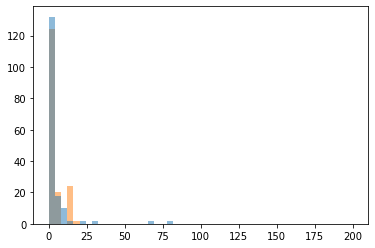

In [8]:
bins = np.linspace(0, 200)
plt.hist(depth_table, bins=bins, alpha=0.5, histtype='stepfilled')
# plt.hist(depth, bins=bins, alpha=0.7)
None

# Tall saw-horse

0it [00:00, ?it/s]<ipython-input-6-168fc7a9bc61>:50: RuntimeWarning: invalid value encountered in true_divide
  proportions_r = np.nan_to_num(send_to_l / total_from_r)
<ipython-input-6-168fc7a9bc61>:51: RuntimeWarning: invalid value encountered in true_divide
  proportions_l = np.nan_to_num(send_to_r / total_from_l)
10it [00:00, 769.77it/s, change=0.000651] 


CONVERGED


,old_depth,new_depth
AACCG,9.0,10.442252
CGGTT,9.0,10.442252
ACCGG,10.0,13.397265
CCGGT,10.0,13.397265
CCGGG,9.0,10.442252
CCCGG,9.0,10.442252
CCGGA,1.0,1.160250
TCCGG,1.0,1.160250
TACCG,1.0,1.160250
CGGTA,1.0,1.160250


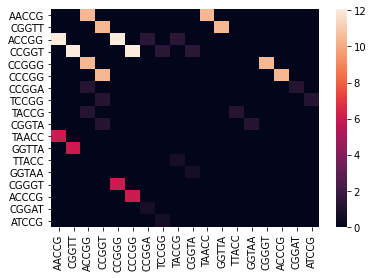

In [9]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
    'TAACC': ['AACCG'],
    'TTACC': ['TACCG'],
    'CCGGG': ['CGGGT'],
    'CCGGA': ['CGGAT'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 9,
    'ACCGG': 10,
    'CCGGG': 9,
    'CCGGA': 1,
    'TACCG': 1,
    'TAACC': 9,
    'TTACC': 1,
    'CGGGT': 9,
    'CGGAT': 1,
})

depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
sns.heatmap(send_to_r + send_to_l)
pd.DataFrame(dict(old_depth=depth0, new_depth=depth))

0it [00:00, ?it/s]<ipython-input-6-168fc7a9bc61>:50: RuntimeWarning: invalid value encountered in true_divide
  proportions_r = np.nan_to_num(send_to_l / total_from_r)
<ipython-input-6-168fc7a9bc61>:51: RuntimeWarning: invalid value encountered in true_divide
  proportions_l = np.nan_to_num(send_to_r / total_from_l)
6it [00:00, 403.80it/s, change=0.000282]

CONVERGED


,old_depth,new_depth
AACCG,3.0,2.636049
CGGTT,3.0,2.636049
ACCGG,4.0,4.970537
CCGGT,4.0,4.970537
CCGGG,3.0,2.636049
CCCGG,3.0,2.636049
CCGGA,1.0,0.878683
TCCGG,1.0,0.878683
TACCG,1.0,0.878683
CGGTA,1.0,0.878683


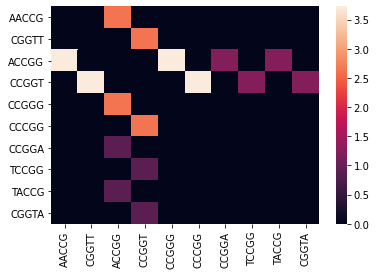

In [10]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 3,
    'ACCGG': 4,
    'CCGGG': 3,
    'CCGGA': 1,
    'TACCG': 1,
})

depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
sns.heatmap(send_to_r + send_to_l)
pd.DataFrame(dict(old_depth=depth0, new_depth=depth))

# Saw-horse

# Cycle w/ Switch-back

20it [00:00, 894.42it/s, change=0.000853] 

CONVERGED


,old_depth,new_depth
ACCCG,1.0,0.857638
CGGGT,1.0,0.857638
CCCGG,1.0,0.857938
CCGGG,1.0,0.857938
CCGGT,1.0,0.857638
ACCGG,1.0,0.857638
CGGTA,1.0,0.856966
TACCG,1.0,0.856966
GGTAC,1.0,1.712854
GTACC,1.0,1.712854


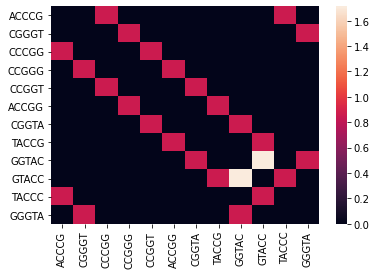

In [11]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGT'],
    'CCGGT': ['CGGTA'],
    'CGGTA': ['GGTAC'],
    'GGTAC': ['GTACC'],
    'GTACC': ['TACCC'],
    'TACCC': ['ACCCG'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGT': 1,
    'CGGTA': 1,
    'GGTAC': 1,
    'GTACC': 1,
    'TACCC': 1,
})

depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
sns.heatmap(send_to_r + send_to_l)
pd.DataFrame(dict(old_depth=depth0, new_depth=depth))

# Six-Cycle

15it [00:00, 203.08it/s, change=0.000932] 


CONVERGED


,old_depth,new_depth
ACCCG,1.0,1.166286
CGGGT,1.0,1.166286
CCCGG,1.0,1.167047
CCGGG,1.0,1.167047
CCGGA,2.0,1.167428
TCCGG,2.0,1.167428
CGGAC,1.0,1.167047
GTCCG,1.0,1.167047
GGACC,1.0,1.166286
GGTCC,1.0,1.166286


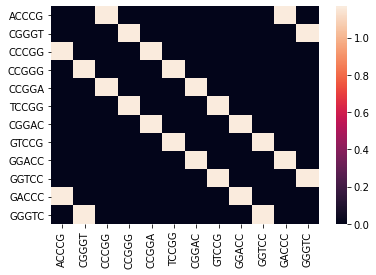

In [12]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    'CGGAC': ['GGACC'],
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG']
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 2,
    'CGGAC': 1,
    'GGACC': 1,
    'GACCC': 1,
})

depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
sns.heatmap(send_to_r + send_to_l)
pd.DataFrame(dict(old_depth=depth0, new_depth=depth))

# Six-cycle w/ Spur

0it [00:00, ?it/s]<ipython-input-6-168fc7a9bc61>:50: RuntimeWarning: invalid value encountered in true_divide
  proportions_r = np.nan_to_num(send_to_l / total_from_r)
<ipython-input-6-168fc7a9bc61>:51: RuntimeWarning: invalid value encountered in true_divide
  proportions_l = np.nan_to_num(send_to_r / total_from_l)
26it [00:00, 745.65it/s, change=0.000901]

CONVERGED


,old_depth,new_depth
ACCCG,1.0,1.167494
CGGGT,1.0,1.167494
CCCGG,1.0,1.167147
CCGGG,1.0,1.167147
CCGGA,1.0,1.165465
TCCGG,1.0,1.165465
CGGAC,1.0,1.165591
GTCCG,1.0,1.165591
GGACC,1.0,1.166311
GGTCC,1.0,1.166311


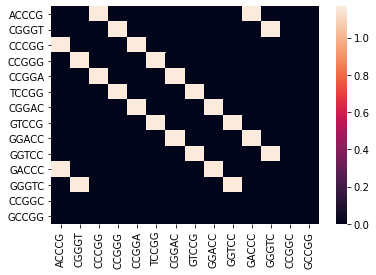

In [13]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA', 'CCGGC'],
    'CCGGA': ['CGGAC'],
    'CGGAC': ['GGACC'],
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG']
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 1,
    'CGGAC': 1,
    'GGACC': 1,
    'GACCC': 1,
    'CCGGC': 1,
})

depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
sns.heatmap(send_to_r + send_to_l)
pd.DataFrame(dict(old_depth=depth0, new_depth=depth))

# Double-six-cycle

1it [00:00, 233.97it/s, change=0] 

CONVERGED


,old_depth,new_depth
GGACC,1.0,1.0
GGTCC,1.0,1.0
GACCC,1.0,1.0
GGGTC,1.0,1.0
ACCCG,1.0,1.0
CGGGT,1.0,1.0
CCCGG,1.0,1.0
CCGGG,1.0,1.0
CCGGA,1.0,1.0
TCCGG,1.0,1.0


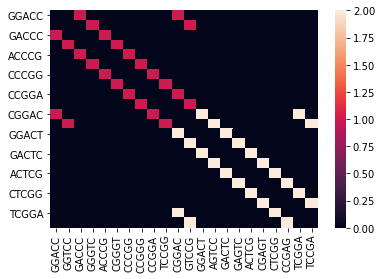

In [14]:
seed = {
    # Top cycle
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG'],
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    
    # Link
    'CGGAC': ['GGACC', 'GGACT'],
    
    # Bottom cycle
    'GGACT': ['GACTC'],
    'GACTC': ['ACTCG'],
    'ACTCG': ['CTCGG'],
    'CTCGG': ['TCGGA'],
    'TCGGA': ['CGGAC'],
    
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    # Top cycle
    'GGACC': 1,
    'GACCC': 1,
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 1,
    
    # Link
    'CGGAC': 3,
    
    # Bottom 
    'GGACT': 2, 
    'GACTC': 2,
    'ACTCG': 2,
    'CTCGG': 2,
    'TCGGA': 2,
})

depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
sns.heatmap(send_to_r + send_to_l)
pd.DataFrame(dict(old_depth=depth0, new_depth=depth))

# Lonely-stick

0it [00:00, ?it/s]<ipython-input-6-168fc7a9bc61>:50: RuntimeWarning: invalid value encountered in true_divide
  proportions_r = np.nan_to_num(send_to_l / total_from_r)
<ipython-input-6-168fc7a9bc61>:51: RuntimeWarning: invalid value encountered in true_divide
  proportions_l = np.nan_to_num(send_to_r / total_from_l)
2it [00:00, 249.81it/s, change=0] 

CONVERGED


,old_depth,new_depth
GGACC,1.0,1.5
GGTCC,1.0,1.5
GACCT,2.0,1.5
AGGTC,2.0,1.5


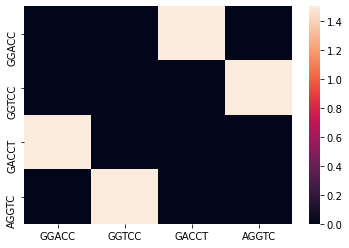

In [15]:
seed = {
    # Top cycle
    'GGACC': ['GACCT'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    # Top cycle
    'GGACC': 1,
    'GACCT': 2,
})

depth, send_to_r, send_to_l, depth0 = run_message_passing(seed, observed_depth)
sns.heatmap(send_to_r + send_to_l)
pd.DataFrame(dict(old_depth=depth0, new_depth=depth))